In [1]:
import re
import ast
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx

from utils_martina.my_utils import *

In [2]:
logs_path = "..\\..\\explainability\GRETEL-repo\\output\\logs\\"
eval_manager_path = "..\\..\\explainability\GRETEL-repo\\output\\eval_manager\\"
output_path = "..\\..\\explainability\GRETEL-repo\\output\\evolution_3d_embeddings\\"

In [3]:
file_name = get_most_recent_file(eval_manager_path).split('.')[0]
print(file_name)

19216-Martina


## Info

In [4]:
# Set patient and record

# ["chb01_03", "chb01_04", "chb01_15", "chb01_16", "chb01_18", "chb01_21", "chb01_26"]
patient_id = "chb01"
record_id = "03"

In [5]:
index_evaluator = 1

### Load data

In [6]:
# Load information related to the EEG of patient_id, record_id
with open(f"EEG_data\EEG_data_params_{patient_id}_{record_id}.pkl", "rb") as f:
    loaded_variables = pickle.load(f)

indices = loaded_variables["indici"]
Start = loaded_variables["Start"]
End = loaded_variables["End"]
seizure_starts = loaded_variables["seizure_starts"]
seizure_ends = loaded_variables["seizure_ends"]
seizure_class = loaded_variables["seizure_class"]
frequency = loaded_variables["frequency"]

In [7]:
# Load logs
with open(logs_path + file_name + '.info', "r") as file:
    content = file.read()

# Load eval_manager
with open(eval_manager_path + file_name + '.pkl', 'rb') as f:
    eval_manager = pickle.load(f)

In [8]:
for i in range(len(eval_manager._evaluators)):
    if i == index_evaluator:
        print(f"---> {eval_manager._evaluators[i]._explainer.name}")
    else:
        print(f"     {eval_manager._evaluators[i]._explainer.name}")

     DCESExplainer-ed16bfbe7c38754502df6bfe31f72747


In [9]:
# Function to plot vertical bands for seizure conditions
def add_seizure_shading(ax, starts, ends, also_horizontal=False):
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, color='yellow', alpha=0.5)

        if also_horizontal:
            ax.axhspan(start, end, color='orange', alpha=0.5)

### Get ids

In [10]:
t_instance = []
t_counterfactual = []

for g1, g2 in eval_manager._evaluators[0].get_instance_explanation_pairs():
    if g1.patient_id == patient_id and g1.record_id == record_id:
        t_instance.append(indices[g1.time] / 256 + Start)
        t_counterfactual.append(indices[g2.time] / 256 + Start)

In [11]:
# Mask
t_instance = np.array(t_instance)
t_counterfactual = np.array(t_counterfactual)
mask = (t_instance > seizure_starts[0]) & (t_instance < seizure_ends[0])

t_counterfactual = t_counterfactual[mask]
t_instance = t_instance[mask]

### Probabilities

In [12]:
prob = []
time = []
id_time = []

for g1 in eval_manager._evaluators[0].dataset.instances:
    if g1.patient_id == patient_id and g1.record_id == record_id:
        logits = eval_manager._evaluators[0]._oracle.predict_proba(g1)
        prob.append(torch.softmax(logits, dim=0))
        time.append(indices[g1.time]/256 + Start)
        id_time.append(g1.time)

prob = np.array(prob)

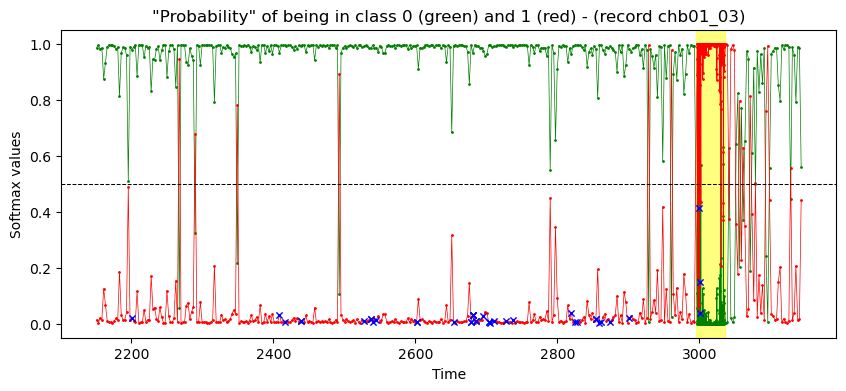

In [13]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(time, prob[:, 0], color='green', linewidth=0.5, marker='o', markersize=1)
ax.plot(time, prob[:, 1], color='red', linewidth=0.5, marker='o', markersize=1)

for t in t_counterfactual:
    if t in time:
        idx = np.where(time == t)[0][0]
        ax.scatter(t, prob[idx, 1], color='blue', linewidth=1, marker='x', s=20, zorder=10)

add_seizure_shading(ax, seizure_starts, seizure_ends)
ax.axhline(0.5, color='black', linewidth=0.75, linestyle='--')
plt.title(f"\"Probability\" of being in class 0 (green) and 1 (red) - (record {patient_id}_{record_id})")
plt.xlabel("Time")
plt.ylabel("Softmax values")
plt.show()

In [1]:
"""fig, ax = plt.subplots(figsize=(10,4))
ax.plot(time, prob[:, 0], color='green', linewidth=1) #, linestyle='dotted')
ax.plot(time, prob[:, 1], color='red', linewidth=1) #, linestyle='dotted')
add_seizure_shading(ax, seizure_starts, seizure_ends)
ax.axhline(0.5, color='black', linewidth=1, linestyle='--')
plt.title(f"Probability of being in  - (record {patient_id}_{record_id})")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.show()"""

'fig, ax = plt.subplots(figsize=(10,4))\nax.plot(time, prob[:, 0], color=\'green\', linewidth=1) #, linestyle=\'dotted\')\nax.plot(time, prob[:, 1], color=\'red\', linewidth=1) #, linestyle=\'dotted\')\nadd_seizure_shading(ax, seizure_starts, seizure_ends)\nax.axhline(0.5, color=\'black\', linewidth=1, linestyle=\'--\')\nplt.title(f"Probability of being in  - (record {patient_id}_{record_id})")\nplt.xlabel("Time")\nplt.ylabel("Probability")\nplt.show()'

In [ ]:
np.save(f'output\probs\prob_{patient_id}_{record_id}.npy', prob[:,1].reshape(-1, 1).astype(np.float32))
np.save(f'output\probs\\time_{patient_id}_{record_id}.npy', time)
np.save(f'output\probs\\id_time_{patient_id}_{record_id}.npy', id_time)

### Distance embeddings

In [2]:
"""expl = eval_manager._evaluators[index_evaluator]._explainer

all_embeddings_record = []

for element in expl.dataset.instances:
    if element.patient_id == patient_id and element.record_id == record_id:
        info = expl.oracle.get_oracle_info(element)
        all_embeddings_record.append(info)"""

'expl = eval_manager._evaluators[index_evaluator]._explainer\n\nall_embeddings_record = []\n\nfor element in expl.dataset.instances:\n    if element.patient_id == patient_id and element.record_id == record_id:\n        info = expl.oracle.get_oracle_info(element)\n        all_embeddings_record.append(info)'

In [3]:
"""norms = []

for i in range(1, len(all_embeddings_record)):
    norm = torch.norm(all_embeddings_record[i]['embeddings']).item()
    diff = all_embeddings_record[i]['embeddings'] - all_embeddings_record[i-1]['embeddings']
    norm_diff = torch.norm(diff).item()  # Calcolo della norma L2 e conversione a float
    
    norms.append({
        'time': indices[i]/256 + Start,
        'norm': norm,
        'norm_diff': norm_diff
    })"""

"norms = []\n\nfor i in range(1, len(all_embeddings_record)):\n    norm = torch.norm(all_embeddings_record[i]['embeddings']).item()\n    diff = all_embeddings_record[i]['embeddings'] - all_embeddings_record[i-1]['embeddings']\n    norm_diff = torch.norm(diff).item()  # Calcolo della norma L2 e conversione a float\n    \n    norms.append({\n        'time': indices[i]/256 + Start,\n        'norm': norm,\n        'norm_diff': norm_diff\n    })"

In [4]:
"""times = [item['time'] for item in norms]
norm_values = [item['norm'] for item in norms]
norm_diff_values = [item['norm_diff'] for item in norms]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.plot(times, norm_values, label='Norm')
add_seizure_shading(ax1, seizure_starts, seizure_ends)
ax1.set_title('Norm of embeddings over time')
ax1.set_ylabel('Norm')
ax1.grid(True)

ax2.plot(times, norm_diff_values, label='Norm Difference', color='orange')
add_seizure_shading(ax2, seizure_starts, seizure_ends)
ax2.set_title('Distance consecutive embeddings over time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Distance')
ax2.grid(True)

plt.tight_layout()
plt.show()"""

"times = [item['time'] for item in norms]\nnorm_values = [item['norm'] for item in norms]\nnorm_diff_values = [item['norm_diff'] for item in norms]\n\nfig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)\nax1.plot(times, norm_values, label='Norm')\nadd_seizure_shading(ax1, seizure_starts, seizure_ends)\nax1.set_title('Norm of embeddings over time')\nax1.set_ylabel('Norm')\nax1.grid(True)\n\nax2.plot(times, norm_diff_values, label='Norm Difference', color='orange')\nadd_seizure_shading(ax2, seizure_starts, seizure_ends)\nax2.set_title('Distance consecutive embeddings over time')\nax2.set_xlabel('Time')\nax2.set_ylabel('Distance')\nax2.grid(True)\n\nplt.tight_layout()\nplt.show()"

### 3D embeddings

In [11]:
"""%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_embeddings_with_metrics_3d(data, title, ax):
    # Label = 0, Prediction = 0
    x_0_correct = [d['embeddings'][0][0] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 0]
    y_0_correct = [d['embeddings'][0][1] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 0]
    z_0_correct = [d['embeddings'][0][2] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 0]

    # Label = 1, Prediction = 1
    x_1_correct = [d['embeddings'][0][0] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 1]
    y_1_correct = [d['embeddings'][0][1] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 1]
    z_1_correct = [d['embeddings'][0][2] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 1]

    # Label = 0, Prediction = 1
    x_0_incorrect = [d['embeddings'][0][0] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 1]
    y_0_incorrect = [d['embeddings'][0][1] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 1]
    z_0_incorrect = [d['embeddings'][0][2] for d in data if d['data_instance_label'] == 0 and d['prediction'] == 1]

    # Label = 1, Prediction = 0
    x_1_incorrect = [d['embeddings'][0][0] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 0]
    y_1_incorrect = [d['embeddings'][0][1] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 0]
    z_1_incorrect = [d['embeddings'][0][2] for d in data if d['data_instance_label'] == 1 and d['prediction'] == 0]

    # Plot 3D embeddings
    ax.scatter(x_0_correct, y_0_correct, z_0_correct, color='blue', label='Label 0 (classified as 0)', alpha=0.2)
    ax.scatter(x_0_incorrect, y_0_incorrect, z_0_incorrect, marker='x', color='midnightblue', label='Label 0 (classified as 1)', alpha=0.9)
    ax.scatter(x_1_correct, y_1_correct, z_1_correct, color='red', label='Label 1 (classified as 1)', alpha=0.2)
    ax.scatter(x_1_incorrect, y_1_incorrect, z_1_incorrect, marker='x', color='darkred', label='Label 1 (classified as 0)', alpha=0.9)

    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    ax.set_zlabel(r'$x_2$')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_embeddings_with_metrics_3d(all_embeddings_record, "3D Embeddings Visualization", ax)
plt.show()"""

'%matplotlib widget\n\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\n\ndef plot_embeddings_with_metrics_3d(data, title, ax):\n    # Label = 0, Prediction = 0\n    x_0_correct = [d[\'embeddings\'][0][0] for d in data if d[\'data_instance_label\'] == 0 and d[\'prediction\'] == 0]\n    y_0_correct = [d[\'embeddings\'][0][1] for d in data if d[\'data_instance_label\'] == 0 and d[\'prediction\'] == 0]\n    z_0_correct = [d[\'embeddings\'][0][2] for d in data if d[\'data_instance_label\'] == 0 and d[\'prediction\'] == 0]\n\n    # Label = 1, Prediction = 1\n    x_1_correct = [d[\'embeddings\'][0][0] for d in data if d[\'data_instance_label\'] == 1 and d[\'prediction\'] == 1]\n    y_1_correct = [d[\'embeddings\'][0][1] for d in data if d[\'data_instance_label\'] == 1 and d[\'prediction\'] == 1]\n    z_1_correct = [d[\'embeddings\'][0][2] for d in data if d[\'data_instance_label\'] == 1 and d[\'prediction\'] == 1]\n\n    # Label = 0, Prediction = 1\n    x_0_incorrect

In [6]:
"""import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from IPython.display import HTML

def extract_point(d):
    emb = d['embeddings'].detach().cpu().numpy()[0]
    return emb[0], emb[1], emb[2]

def animate_points_3d(data, save_path=None):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    xs_all = [extract_point(d)[0] for d in data]
    ys_all = [extract_point(d)[1] for d in data]
    zs_all = [extract_point(d)[2] for d in data]

    ax.set_xlim(min(xs_all)*1.1, max(xs_all)*1.1)
    ax.set_ylim(min(ys_all)*1.1, max(ys_all)*1.1)
    ax.set_zlim(min(zs_all)*1.1, max(zs_all)*1.1)

    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_zlabel('x2')
    ax.set_title('Embedding points animation by data_instance_id')

    # Scatter iniziale vuoto
    scat = ax.scatter([], [], [], facecolors=[], s=50, marker='o', edgecolors='none')

    data_sorted = sorted(data, key=lambda x: x['data_instance_id'])

    xs, ys, zs, colors = [], [], [], []

    def update(frame):
        d = data_sorted[frame]
        x, y, z = extract_point(d)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        label = d['data_instance_label']
        color = 'green' if label == 0 else 'red'
        colors.append(color)
        scat._offsets3d = (xs, ys, zs)
        scat.set_facecolor(colors)
        ax.set_title(f'Showing data_instance_id = {d["data_instance_id"]} ({d["data_instance_label"]})')
        return scat,

    ani = animation.FuncAnimation(
        fig, update, frames=len(data_sorted), interval=200, blit=False
    )

    # Se vuoi salvare su file
    if save_path:
        ani.save(save_path, writer='ffmpeg', fps=5)
        plt.close(fig)
    else:
        plt.close(fig)
        return HTML(ani.to_jshtml())
"""

'import matplotlib.pyplot as plt\nimport matplotlib.animation as animation\nfrom mpl_toolkits.mplot3d import Axes3D\nimport numpy as np\nfrom IPython.display import HTML\n\ndef extract_point(d):\n    emb = d[\'embeddings\'].detach().cpu().numpy()[0]\n    return emb[0], emb[1], emb[2]\n\ndef animate_points_3d(data, save_path=None):\n    fig = plt.figure(figsize=(8,6))\n    ax = fig.add_subplot(111, projection=\'3d\')\n\n    xs_all = [extract_point(d)[0] for d in data]\n    ys_all = [extract_point(d)[1] for d in data]\n    zs_all = [extract_point(d)[2] for d in data]\n\n    ax.set_xlim(min(xs_all)*1.1, max(xs_all)*1.1)\n    ax.set_ylim(min(ys_all)*1.1, max(ys_all)*1.1)\n    ax.set_zlim(min(zs_all)*1.1, max(zs_all)*1.1)\n\n    ax.set_xlabel(\'x0\')\n    ax.set_ylabel(\'x1\')\n    ax.set_zlabel(\'x2\')\n    ax.set_title(\'Embedding points animation by data_instance_id\')\n\n    # Scatter iniziale vuoto\n    scat = ax.scatter([], [], [], facecolors=[], s=50, marker=\'o\', edgecolors=\'none\

In [7]:
"""from IPython.display import display

# Mostra animazione nel notebook
html_anim = animate_points_3d(all_embeddings_record)
display(html_anim)"""

'from IPython.display import display\n\n# Mostra animazione nel notebook\nhtml_anim = animate_points_3d(all_embeddings_record)\ndisplay(html_anim)'

In [8]:
"""import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3D
from IPython.display import HTML
import numpy as np

def extract_point(d):
    emb = d['embeddings'].detach().cpu().numpy()[0]
    return emb[0], emb[1], emb[2]

def animate_points_3d(data, save_path, show_line=False):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Estrai tutti i valori per impostare limiti
    xs_all = [extract_point(d)[0] for d in data]
    ys_all = [extract_point(d)[1] for d in data]
    zs_all = [extract_point(d)[2] for d in data]

    ax.set_xlim(min(xs_all)*1.1, max(xs_all)*1.1)
    ax.set_ylim(min(ys_all)*1.1, max(ys_all)*1.1)
    ax.set_zlim(min(zs_all)*1.1, max(zs_all)*1.1)

    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_zlabel('x2')
    ax.set_title('Embedding points animation by data_instance_id')

    # Scatter vuoto iniziale
    scat = ax.scatter([], [], [], facecolors=[], s=50, marker='o', edgecolors='none')

    if show_line:
        # Linea vuota per collegare i punti
        line = Line3D([], [], [], color='gray', linewidth=1.5)
        ax.add_line(line)

    data_sorted = sorted(data, key=lambda x: x['data_instance_id'])

    xs, ys, zs, colors = [], [], [], []

    def update(frame):
        d = data_sorted[frame]
        x, y, z = extract_point(d)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        label = d['data_instance_label']
        color = 'green' if label == 0 else 'red'
        colors.append(color)

        # Aggiorna scatter
        scat._offsets3d = (xs, ys, zs)
        scat.set_facecolor(colors)

        if show_line:
            # Aggiorna la linea
            line.set_data(xs, ys)
            line.set_3d_properties(zs)

            ax.set_title(f'Showing data_instance_id = {d["data_instance_id"]}')
            return scat, line
        else:
            ax.set_title(f'Showing data_instance_id = {d["data_instance_id"]}')
            return scat

    ani = animation.FuncAnimation(
        fig, update, frames=len(data_sorted), interval=200, blit=False
    )
    
    ani.save(save_path, writer='ffmpeg', fps=20)
    plt.close(fig)"""

'import matplotlib.pyplot as plt\nimport matplotlib.animation as animation\nfrom mpl_toolkits.mplot3d import Axes3D\nfrom mpl_toolkits.mplot3d.art3d import Line3D\nfrom IPython.display import HTML\nimport numpy as np\n\ndef extract_point(d):\n    emb = d[\'embeddings\'].detach().cpu().numpy()[0]\n    return emb[0], emb[1], emb[2]\n\ndef animate_points_3d(data, save_path, show_line=False):\n    fig = plt.figure(figsize=(10, 8))\n    ax = fig.add_subplot(111, projection=\'3d\')\n\n    # Estrai tutti i valori per impostare limiti\n    xs_all = [extract_point(d)[0] for d in data]\n    ys_all = [extract_point(d)[1] for d in data]\n    zs_all = [extract_point(d)[2] for d in data]\n\n    ax.set_xlim(min(xs_all)*1.1, max(xs_all)*1.1)\n    ax.set_ylim(min(ys_all)*1.1, max(ys_all)*1.1)\n    ax.set_zlim(min(zs_all)*1.1, max(zs_all)*1.1)\n\n    ax.set_xlabel(\'x0\')\n    ax.set_ylabel(\'x1\')\n    ax.set_zlabel(\'x2\')\n    ax.set_title(\'Embedding points animation by data_instance_id\')\n\n    # 

In [9]:
"""save_path = f"{output_path}{file_name.split('-')[0]}_{patient_id}_{record_id}.mp4"
html_anim = animate_points_3d(all_embeddings_record, save_path=save_path, show_line=True)"""

'save_path = f"{output_path}{file_name.split(\'-\')[0]}_{patient_id}_{record_id}.mp4"\nhtml_anim = animate_points_3d(all_embeddings_record, save_path=save_path, show_line=True)'

## _______________________________________________________________

In [ ]:
import datetime

now = datetime.datetime.now()
print("Last full run:", now.strftime("%d/%m/%Y, ore %H:%M"))

Last full run: 30/05/2025, ore 21:07
